# Car Sales Forecasting

### Problem statement: Given historical monthly car sales data, predict car sales for 12 months in future

### Importing required libraries

In [203]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings("ignore")

pl.rcParams['figure.figsize'] = (12, 10)

### Loading data & basic preprocessing

In [204]:
# load data
ts = pd.read_csv('monthly-car-sales.csv')
ts.tail()

,Month,Sales
103,1968-08,16722
104,1968-09,14385
105,1968-10,21342
106,1968-11,17180
107,1968-12,14577


**As per the given dataset, 'Sales' column has monthly sales for corresponding month in the 'Month' column**

In [205]:
ts['Month'] = pd.to_datetime(ts['Month'])
ts

,Month,Sales
0,1960-01-01,6550
1,1960-02-01,8728
2,1960-03-01,12026
3,1960-04-01,14395
4,1960-05-01,14587
...,...,...
103,1968-08-01,16722
104,1968-09-01,14385
105,1968-10-01,21342
106,1968-11-01,17180


**It is imperative to check for the datatype of the columns before we proceed with our EDA and modeling steps.
It seems the 'Month' column is loaded as an object datatype. We will have to format the column correctly to date datatype.**

**Also, no missing values can be seen in the dataset**

In [206]:
ts['Month'] = pd.to_datetime(ts['Month'])
ts.set_index('Month', inplace=True)
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 1960-01-01 to 1968-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   108 non-null    int64
dtypes: int64(1)
memory usage: 1.7 KB


### Exploratory Data Analysis

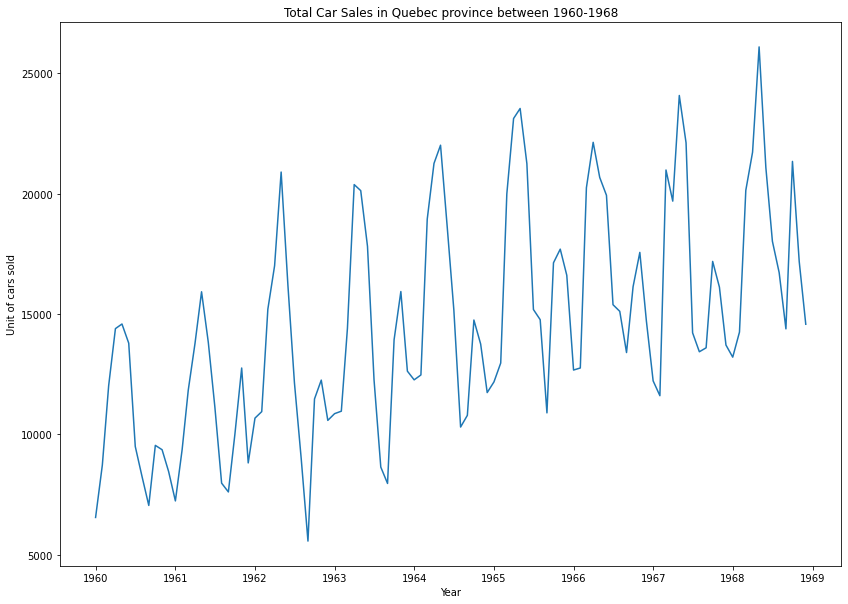

In [207]:
# Plotting car sales through the years
plt.figure(figsize=(14, 10))
plt.title('Total Car Sales in Quebec province between 1960-1968')
plt.xlabel('Year')
plt.ylabel('Unit of cars sold')
plt.plot(ts);

**Some of the observation from the above plot.**

**1. There is an obvious "seasonality" (for eg: peak car sales around a particular time of year**

**2. There is an increasing "Trend" (sales have increased with each passing year).**

**3. The seasonal signal appears to be growing over time, suggesting a multiplicative relationship (increasing change)**

**4. There appears to be 1 obvious outlier somewhere towards the end of 1962.**

**5. The seasonality suggests that the series is almost certainly non-stationary.**

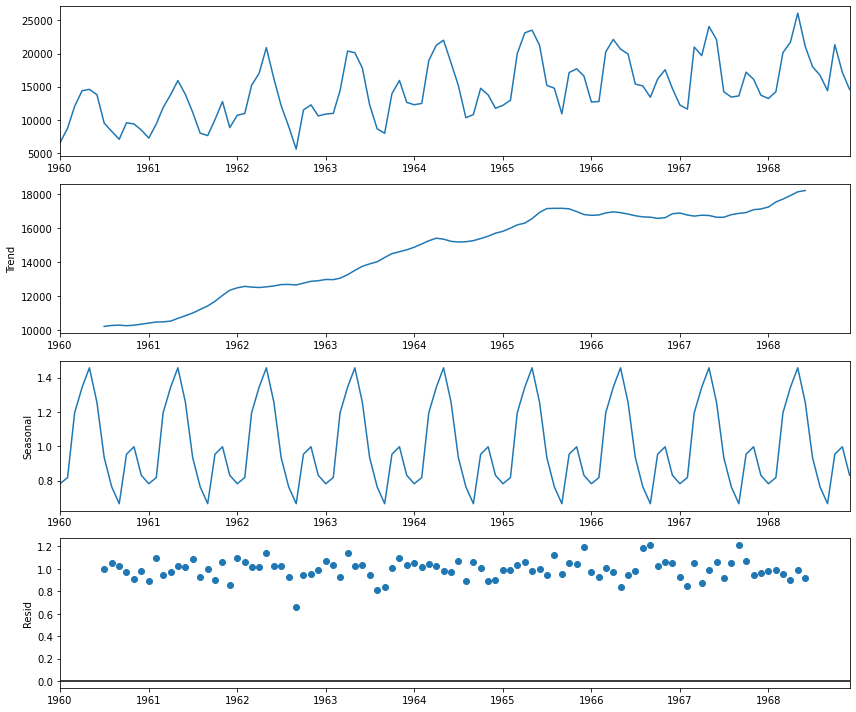

In [208]:
# Time series decomposition using multiplicative model
res = sm.tsa.seasonal_decompose(ts, period=12, model="multiplicative")
res.plot()
plt.show()

**Stationarity refers to time-invariance of a series. Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward). When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.**

**There are multiple tests that can be used to check stationarity. One such test is ADF(Augmented Dicky Fuller Test)**

In [209]:
# Checking for stationarity of the time series
def test_stationarity(ts):
    df_adf = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(df_adf[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in df_adf[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Test Statistic                 -1.223813
p-value                         0.663269
Lags Used                      12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


**The ADF test is a type of statistical test called a unit root test. 
The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary. The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.
From the above test statistics, we can see thet p-value > 0.05. Thus, we fail to reject the null hypothesis and this indicates that the time series has a unit root and it is non-stationary.**

**Observing from the decomposed plot of the time series, we can see sales has an increasing trend. One of the preprocessing steps we can perform is detrending (removing trend of from the time series) the timeseries. This helps to more easily observe subtrends in the data that are seasonal.**

In [210]:
# Detrending the time series
def difference(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return pd.Series(diff)

[]

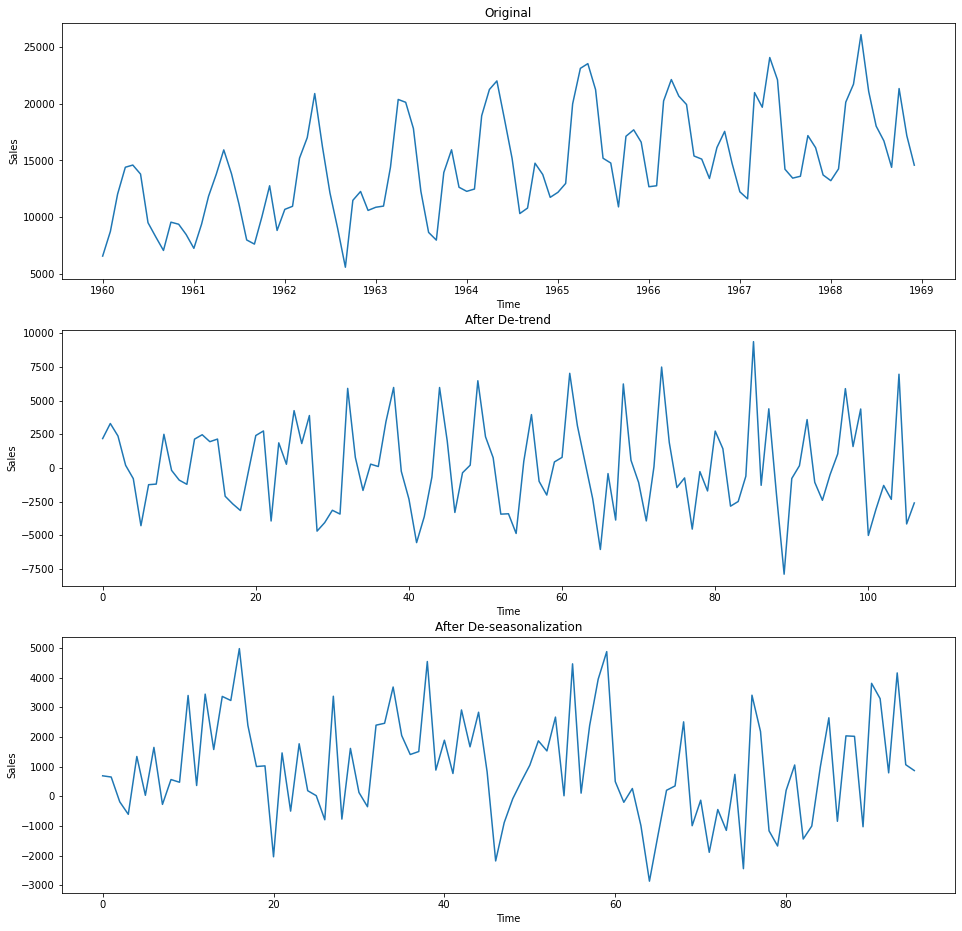

In [211]:
# Plotting OG, de-trended and differenced ts
plt.figure(figsize=(16,16))

plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts.values)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts.values, 12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [212]:
# Using ADF to check if the detrending and de-seasonalization made the time series stationary
test_stationarity(new_ts)

Test Statistic                 -3.644397
p-value                         0.004967
Lags Used                      11.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


**From the above test statistics, p-value for the ADF test is less than 0.05. Hence we can reject null hypothesis and assume stationarity of the series**

**The original series can be derived back using the inverse transform function.**

In [213]:
# Invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

## Modeling

**Now that we have made the time series stationary, we can start with the modeling proceess. The baseline model
that we can experiment with is ARIMA as it is one of the basic yet effective statistical model for forecasting**

**For ARIMA, we have the following parameters:**

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

**In our case, we have already have observd that the d = 1 as after differencing the time series, it became stationary.**

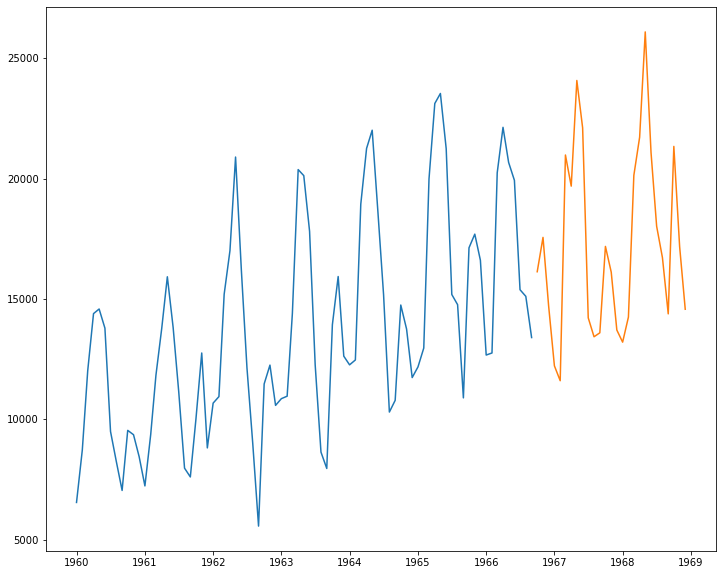

In [222]:
# prepare training dataset
X = ts
split = int(len(X) * 0.75)
train, test = X[0:split], X[split:]

# plotting train and test dataset
plt.plot(train)
plt.plot(test)

### Approach I: ARIMA model and manual optimization of p, d, q parameters

ARIMA(0, 1, 1) RMSE=3736.832
ARIMA(0, 1, 2) RMSE=3909.012
ARIMA(0, 1, 3) RMSE=3219.976
ARIMA(0, 2, 1) RMSE=3683.499
ARIMA(0, 2, 2) RMSE=3773.228
ARIMA(0, 2, 3) RMSE=3948.532
ARIMA(0, 3, 1) RMSE=5162.704
ARIMA(0, 3, 2) RMSE=3748.578
ARIMA(0, 3, 3) RMSE=3858.845
ARIMA(1, 1, 1) RMSE=3453.139
ARIMA(1, 1, 2) RMSE=3349.978
ARIMA(1, 1, 3) RMSE=3307.203
ARIMA(1, 2, 1) RMSE=3785.279
ARIMA(1, 2, 2) RMSE=3730.622
ARIMA(1, 2, 3) RMSE=3913.367
ARIMA(1, 3, 1) RMSE=4770.769
ARIMA(1, 3, 2) RMSE=4285.928
ARIMA(1, 3, 3) RMSE=3536.414
ARIMA(2, 1, 1) RMSE=3298.695
ARIMA(2, 1, 2) RMSE=3084.616
ARIMA(2, 1, 3) RMSE=3364.977
ARIMA(2, 2, 1) RMSE=3800.788
ARIMA(2, 2, 2) RMSE=3425.623
ARIMA(2, 2, 3) RMSE=3681.613
ARIMA(2, 3, 1) RMSE=4772.210
ARIMA(2, 3, 2) RMSE=4648.815
ARIMA(2, 3, 3) RMSE=4578.176
ARIMA(4, 1, 1) RMSE=3287.869
ARIMA(4, 1, 2) RMSE=3281.502
ARIMA(4, 1, 3) RMSE=3143.652
ARIMA(4, 2, 1) RMSE=3643.896
ARIMA(4, 2, 2) RMSE=3295.579
ARIMA(4, 2, 3) RMSE=3565.851
ARIMA(4, 3, 1) RMSE=3691.022
ARIMA(4, 3, 2)

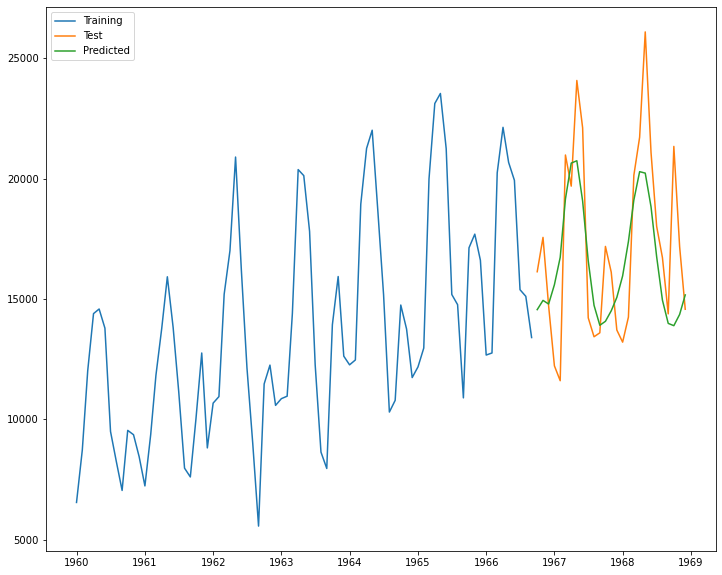

In [215]:
# Modeling approach I: Evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    
    # prepare training dataset
    split = int(len(X) * 0.66)
    train, test = X[0:split], X[split:]
    history = [x for x in train]
    
    # make predictions
    predictions = list()
    for t in range(len(test)):
        try:
            mdl = ARIMA(history, order=arima_order)
            fitted_mdl = mdl.fit()
            yhat = fitted_mdl.forecast()[0]
            predictions.append(yhat)
            history.append(test[t])
        except:
            continue
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(data, p_values, d_values, q_values):
    data = data.astype('float32')
    best_score, best_pdq = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(data, order)
                    if rmse < best_score:
                        best_score, best_pdq = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_pdq, best_score))
    
X = ts.values
p_values = [0, 1, 2, 4, 5, 6, 7, 8]
d_values = range(1, 4)
q_values = range(1, 4)
evaluate_models(X, p_values, d_values, q_values)

mdl1 = ARIMA(train, order=(8,1,2))
fitted_mdl1 = mdl1.fit()

# Test set predictions using model I
prediction1 = fitted_mdl1.forecast(steps=27)

plt.figure(figsize=(12,10))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction1,label="Predicted")
plt.legend()
plt.show()

In [216]:
# Model evaluation of model I and prediction for out of sample data
print(f'R2_score: {(r2_score(test.Sales, prediction1))}')
print(f'RMSE: {(np.sqrt(mean_squared_error(test.Sales, prediction1)))}')

R2_score: 0.42493156159669576
RMSE: 2865.8003327540196


### Approach I: ARIMA model and optimization of p, d, q parametrs using auto_arima() function from pmdarima library

<Figure size 864x720 with 0 Axes>

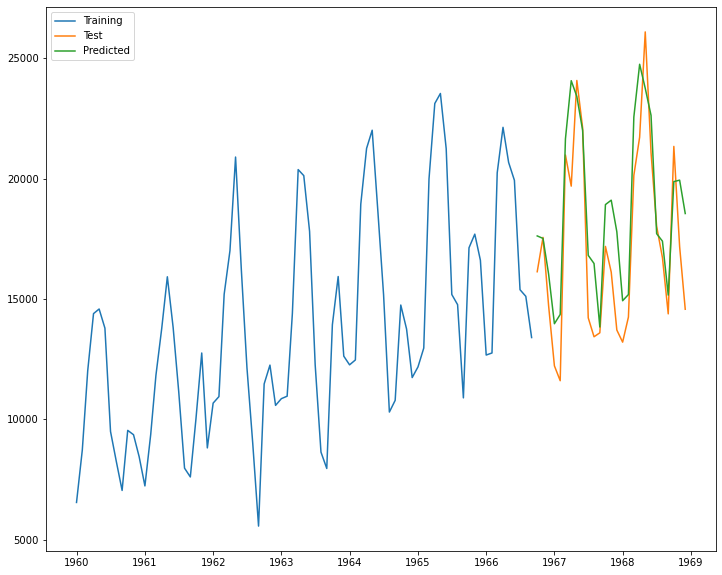

In [217]:
# Modeling approach II: Optimizing parameters using Auto Arima lib
fitted_mdl2 =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=8, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=8, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

# Test set predictions using model II
prediction1 = fitted_mdl2.predict(n_periods=27)
plt.clf()
plt.figure(figsize=(12,10))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction2,label="Predicted")
plt.legend()
plt.show()

In [218]:
# Model evaluation of model I and prediction for out of sample data
print(f'R2_score: {(r2_score(test.Sales, prediction2))}')
print(f'RMSE: {(np.sqrt(mean_squared_error(test.Sales, prediction2)))}')

R2_score: 0.6554451559493928
RMSE: 2218.2747836499652


**We can see that the model II is a better fit both in terms of r2_score and rmse. So, lets train the model II on the entire dataset and predict for out of sample (1969)**

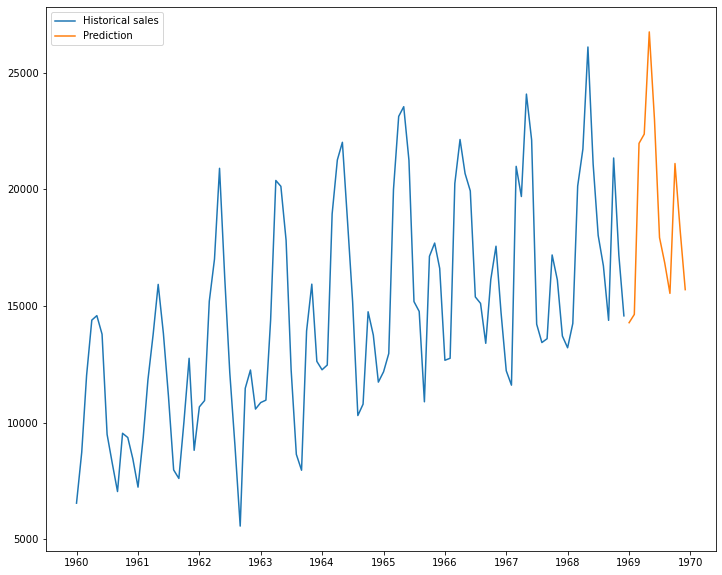

In [228]:
# Prediction for next 12 months using model II
#Training on the entire dataset and predicting for 1969
final_mdl =  auto_arima(X, start_p=0, d=1, start_q=0, 
                          max_p=8, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=8, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits=50)

# Model prediction using model II AND prediction for out of sample data
prediction = final_mdl.predict(n_periods = 12)
idx = pd.date_range(start='1/1/1969', end='12/1/1969', freq='MS')
sales_1969 = pd.DataFrame({'Sales':prediction}, index=idx)
sales_1969.index.name = 'Month'

# Plotting historical sales till 1968 and predicted sales for 1969
plt.figure(figsize=(12,10))
plt.plot(X, label='Historical sales')
plt.plot(sales_1969, label='Prediction')
plt.legend()
plt.show()

In [229]:
print(f'Predicted sales for the year of 1969: \n\n {sales_1969}')

Predicted sales for the year of 1969: 

                    Sales
Month                   
1969-01-01  14283.877441
1969-02-01  14639.465749
1969-03-01  21969.806758
1969-04-01  22365.637723
1969-05-01  26745.838673
1969-06-01  22990.871747
1969-07-01  17932.512206
1969-08-01  16843.824892
1969-09-01  15540.729983
1969-10-01  21105.409972
1969-11-01  18222.459294
1969-12-01  15700.898439
